<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./




Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

True

## Config Training Parameters

In [5]:
from dotenv import load_dotenv
import pandas as pd
import os

# load from .env file or OS vars if available
load_dotenv()

n_stocks = int(os.getenv("n_stocks", 50)) # -1 for all, otherwise a number like 300
print('n_stocks: ', n_stocks)
n_epochs = int(os.getenv("n_epochs", 5)) # model training epochs
print('n_epochs: ', n_epochs)

# pick the earlies date after which market data is available for all covariate series
train_date_start = pd.Timestamp(os.getenv("train_date_start", '1991-01-01'))



n_stocks:  50
n_epochs:  5


In [6]:
# How far back should the model look in order to make a prediction
train_history = 252*2 # 252 days in a year with market data
# How far into the future should the model forecast
pred_horizon = 21*2 # 21 days in a month with market data


In [7]:

n_test_range_days = train_history+3*pred_horizon
print(f'n_test_range_days: {n_test_range_days}')


# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = n_test_range_days*3
print(f'min_samples: {min_samples}')

n_test_range_days: 630
min_samples: 1890


## Load Target Series Data

Load data from prepared local csv files

In [8]:
from darts import TimeSeries
import pandas as pd


Load price history
* Then split into target series and past covariates

In [10]:
stocks_price_file = 'data/all_stocks_price_hist.csv.bz2'

In [11]:

from canswim import targets

ticker_dict = targets.load_stock_prices(csv_file=stocks_price_file, min_samples=min_samples)



In [194]:
stock_tickers = list(set(ticker_dict.keys()))

len(stock_tickers)


1855

In [195]:
import random

# reduce ticker set to a workable size for the training loop
stock_tickers = random.sample(stock_tickers, n_stocks)

In [196]:
print(list(stock_tickers))

['DEA', 'AGM', 'COMM', 'SXT', 'NWN', 'ES', 'CCRD', 'SYY', 'OZK', 'PRTS', 'SNDX', 'ASND', 'HII', 'KAI', 'BAC', 'HAE', 'EA', 'CUBI', 'CRH', 'ORCL', 'FCPT', 'PRDO', 'NYMT', 'ONB', 'NTLA', 'CNTY', 'TFC', 'HCI', 'AAL', 'IMKTA', 'RNAC', 'DBRG', 'RDNT', 'SPTN', 'RBCAA', 'ABCB', 'FATE', 'RGR', 'AFL', 'KW', 'BCO', 'EWBC', 'PIPR', 'FBMS', 'HROW', 'SCVL', 'LNN', 'CMT', 'BDX', 'PKG']


In [197]:

from canswim import targets

ticker_train_dict = dict((k, ticker_dict[k]) for k in stock_tickers)
ticker_series = targets.prepare_ticker_series(ticker_dict=ticker_train_dict, train_date_start=train_date_start)


Preparing ticker series for 50 stocks.
Ticker series dict created.
ticker: DEA gaps: 
     gap_start    gap_end  gap_size
0  2015-02-16 2015-02-16         1
1  2015-04-03 2015-04-03         1
2  2015-05-25 2015-05-25         1
3  2015-07-03 2015-07-03         1
4  2015-09-07 2015-09-07         1
..        ...        ...       ...
78 2023-09-04 2023-09-04         1
79 2023-11-23 2023-11-23         1
80 2023-12-25 2023-12-25         1
81 2024-01-01 2024-01-01         1
82 2024-01-15 2024-01-15         1

[83 rows x 3 columns]
ticker: AGM gaps: 
      gap_start    gap_end  gap_size
0   1994-02-21 1994-02-21         1
1   1994-04-01 1994-04-01         1
2   1994-04-27 1994-04-27         1
3   1994-05-30 1994-05-30         1
4   1994-07-04 1994-07-04         1
..         ...        ...       ...
265 2023-09-04 2023-09-04         1
266 2023-11-23 2023-11-23         1
267 2023-12-25 2023-12-25         1
268 2024-01-01 2024-01-01         1
269 2024-01-15 2024-01-15         1

[270 rows x 3 col

Prepare multiple series - one per stock ticker

In [198]:
ticker_series

{'DEA': <TimeSeries (DataArray) (Date: 2337, component: 7, sample: 1)>
 array([[[1.62500000e+01],
         [1.64400005e+01],
         [1.55000000e+01],
         ...,
         [9.72927856e+00],
         [3.49810000e+06],
         [0.00000000e+00]],
 
        [[1.54899998e+01],
         [1.59399996e+01],
         [1.51800003e+01],
         ...,
         [9.91758633e+00],
         [4.46300000e+05],
         [0.00000000e+00]],
 
        [[1.56000004e+01],
         [1.62500000e+01],
         [1.54700003e+01],
         ...,
 ...
         ...,
         [1.27500000e+01],
         [8.08800000e+05],
         [0.00000000e+00]],
 
        [[1.28199997e+01],
         [1.30050001e+01],
         [1.27100000e+01],
         ...,
         [1.29899998e+01],
         [9.73600000e+05],
         [0.00000000e+00]],
 
        [[1.31000004e+01],
         [1.31899996e+01],
         [1.30299997e+01],
         ...,
         [1.30398998e+01],
         [4.04175000e+05],
         [0.00000000e+00]]])
 Coordinates:
  

In [199]:
# prepare target univariate series for Close price
# target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}

target_columns = ['Open', 'Close']

target_series = targets.prepare_target_series(ticker_series=ticker_series, target_columns=target_columns)

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [217]:
from canswim import covariates

price_covariates = covariates.get_price_covariates(ticker_series=ticker_series, target_columns=target_columns)


In [203]:
price_covariates.keys()

dict_keys(['DEA', 'AGM', 'COMM', 'SXT', 'NWN', 'ES', 'CCRD', 'SYY', 'OZK', 'PRTS', 'SNDX', 'ASND', 'HII', 'KAI', 'BAC', 'HAE', 'EA', 'CUBI', 'CRH', 'ORCL', 'FCPT', 'PRDO', 'NYMT', 'ONB', 'NTLA', 'CNTY', 'TFC', 'HCI', 'AAL', 'IMKTA', 'RNAC', 'DBRG', 'RDNT', 'SPTN', 'RBCAA', 'ABCB', 'FATE', 'RGR', 'AFL', 'KW', 'BCO', 'EWBC', 'PIPR', 'FBMS', 'HROW', 'SCVL', 'LNN', 'CMT', 'BDX', 'PKG'])

DEA past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
AGM past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
COMM past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
SXT past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

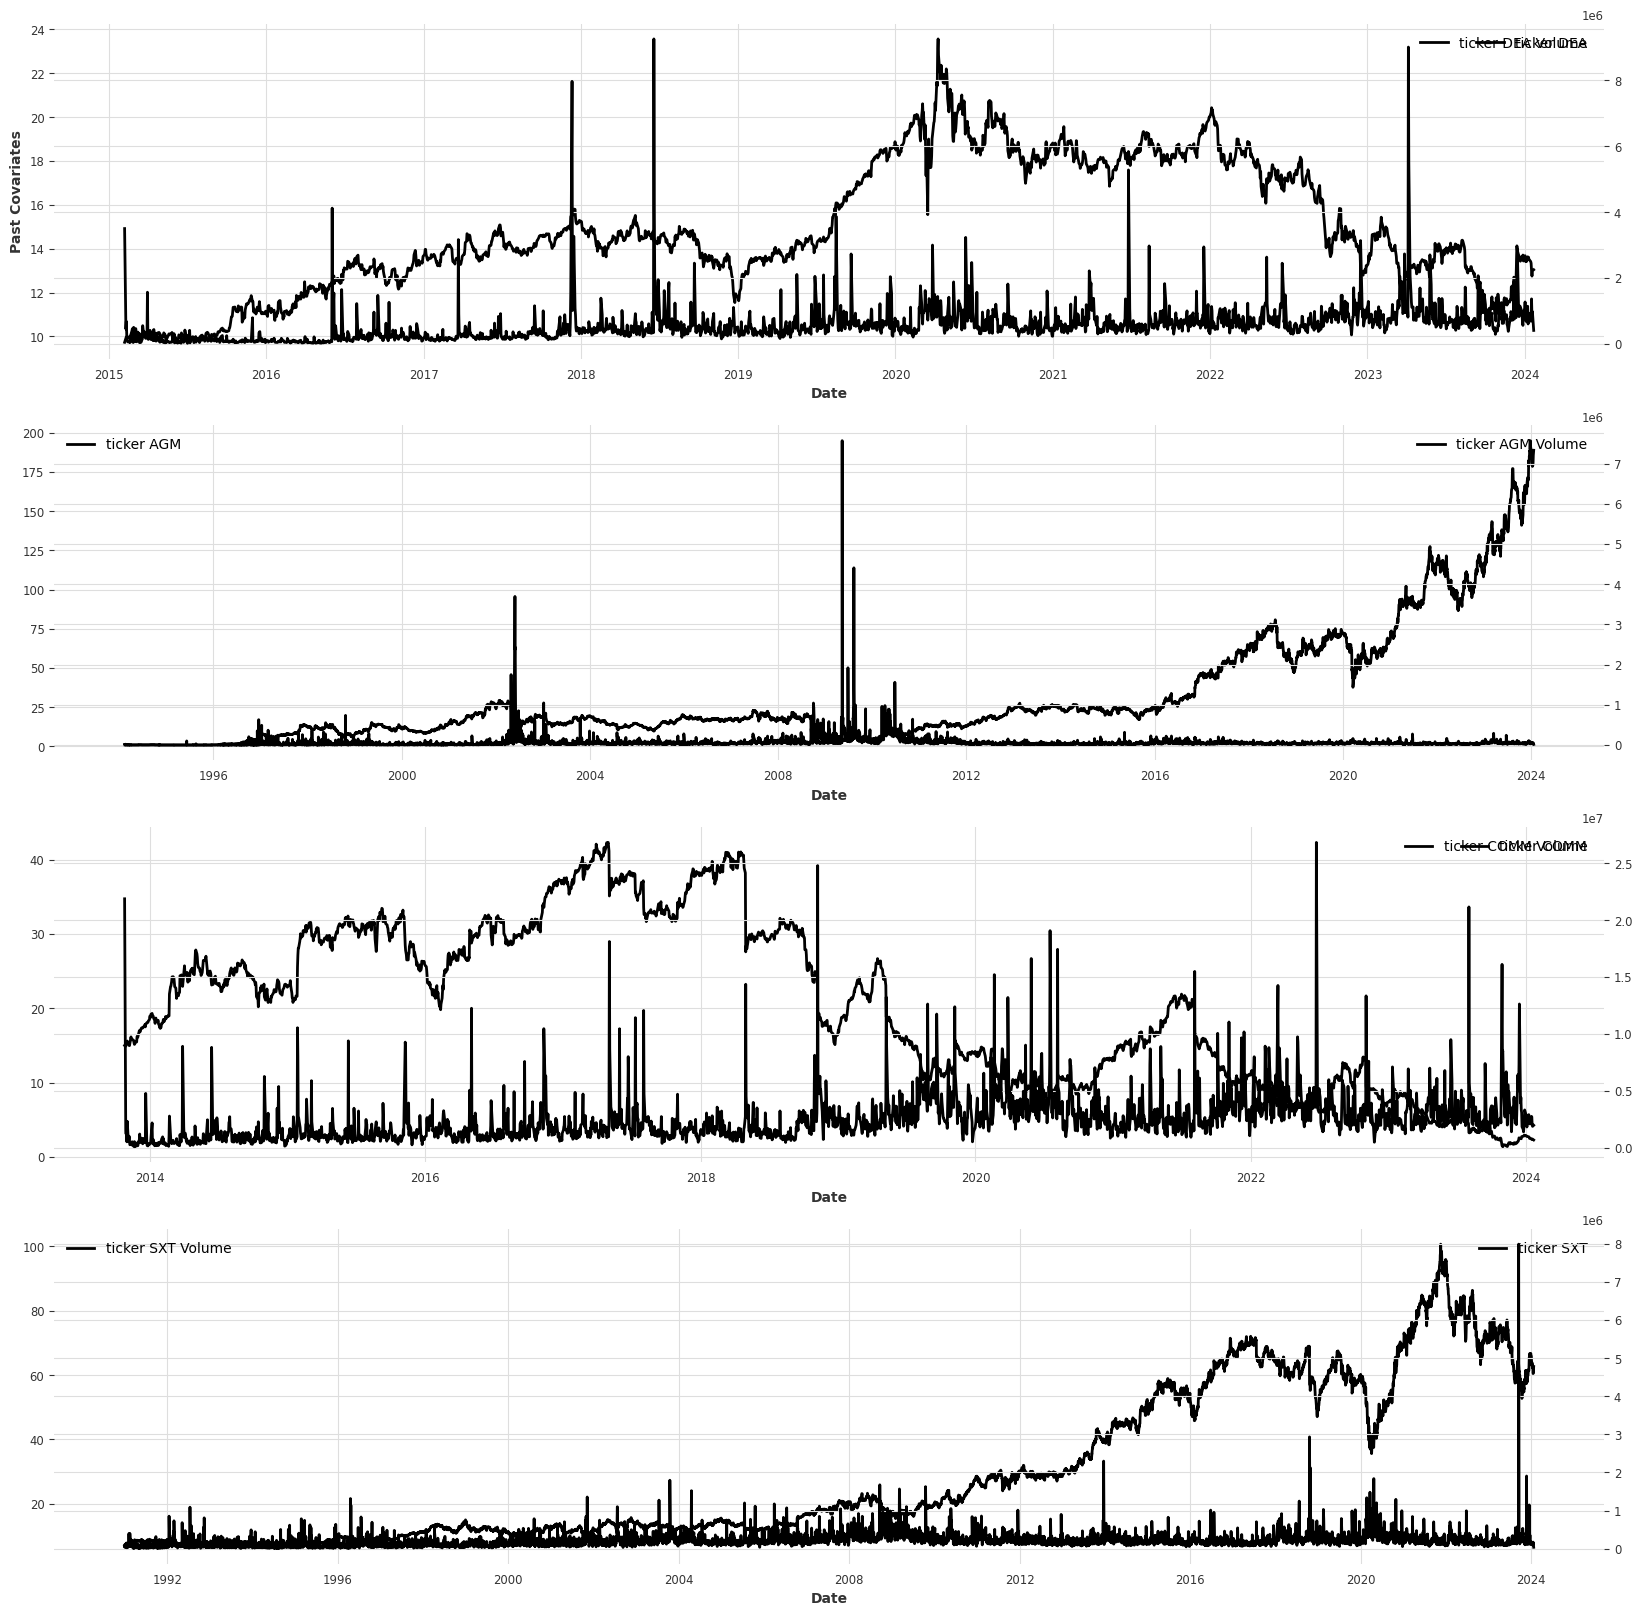

In [206]:
import matplotlib.pyplot as plt


n_plot_samples = 4

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(price_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {price_covariates[t].columns}')
        price_covariates[t].univariate_component('Adj Close').plot(label=f'ticker {t} ', ax=axes[i])
        price_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes2[i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [219]:
from canswim import covariates

earnings_csv_file = 'data/earnings_calendar.csv.bz2'

earn_covariates = covariates.prepare_earn_series(csv_file=earnings_csv_file, tickers=ticker_series.keys())

       symbol        date     eps  epsEstimated time       revenue  \
0          CF  2024-10-31     NaN           NaN  amc           NaN   
1          CF  2024-08-08     NaN           NaN  amc           NaN   
2          CF  2024-05-02     NaN           NaN  amc           NaN   
3          CF  2024-02-14     NaN          1.56  bmo           NaN   
4          CF  2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...         ...     ...           ...  ...           ...   
214890    GPI  1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI  1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI  1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI  1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI  1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-2

In [220]:
earn_covariates[t].start_time(), earn_covariates[t].end_time()

(Timestamp('1999-03-31 00:00:00'), Timestamp('2024-09-16 00:00:00'))

In [223]:
from canswim import covariates

past_covariates = covariates.stack_covariates(old_covs=price_covariates, new_covs=earn_covariates)

In [224]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2000-01-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [225]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component      High   Low  Adj Close      Volume  eps  epsEstimated  time  \
Date                                                                        
2000-01-28  12.1875  12.0   6.088477  11192000.0 -1.0          0.21   0.0   
2000-01-31  12.0625  12.0   6.120187   1880900.0 -1.0          0.21   0.0   
2000-02-01  12.0625  12.0   6.088477    367100.0 -1.0          0.21   0.0   
2000-02-02  12.0625  12.0   6.120187    697400.0 -1.0          0.21   0.0   
2000-02-03  12.0625  12.0   6.088477    579800.0 -1.0          0.21   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
2000-01-28     -1.0      4.542682e+08                 -1.0   
2000-01-31     -1.0      4.542682e+08                 -1.0   
2000-02-01     -1.0      4.542682e+08                 -1.0   
2000-02-02     -1.0      4.542682e+08                 -1.0   
2000-02-03     -1.0      4.542682e+08   

### Add key metrics to past covariates

In [226]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [227]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

       symbol        date  calendarYear period  revenuePerShare  \
0          CF  2023-09-30          2023     Q3         6.616424   
1          CF  2023-06-30          2023     Q2         9.121274   
2          CF  2023-03-31          2023     Q1        10.254842   
3          CF  2022-12-31          2022     Q4        13.265514   
4          CF  2022-09-30          2022     Q3        11.593407   
...       ...         ...           ...    ...              ...   
212738    GPI  1998-03-31          1998     Q1        17.199677   
212739    GPI  1997-12-31          1997     Q4        14.442580   
212740    GPI  1997-09-30          1997     Q3        16.058000   
212741    GPI  1997-06-30          1997     Q2        15.281429   
212742    GPI  1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119              

In [228]:
assert kms_loaded_df.index.is_unique

In [229]:
kms_loaded_df.index

RangeIndex(start=0, stop=212743, step=1)

In [230]:
len(kms_loaded_df.index)

212743

In [231]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [232]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [233]:
assert not kms_unique.duplicated().any()

In [234]:
kms_unique

symbol       date  calendarYear period  revenuePerShare  \
0          CF 2023-09-30          2023     Q3         6.616424   
1          CF 2023-06-30          2023     Q2         9.121274   
2          CF 2023-03-31          2023     Q1        10.254842   
3          CF 2022-12-31          2022     Q4        13.265514   
4          CF 2022-09-30          2022     Q3        11.593407   
...       ...        ...           ...    ...              ...   
212738    GPI 1998-03-31          1998     Q1        17.199677   
212739    GPI 1997-12-31          1997     Q4        14.442580   
212740    GPI 1997-09-30          1997     Q3        16.058000   
212741    GPI 1997-06-30          1997     Q2        15.281429   
212742    GPI 1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119                   3.658787              3.170606   
2                2.854230                   4.826707              4.475025   
3                4.374364                   2.975585              2.293998   
4                2.187812                   4.945055              3.996004   
...                   ...                        ...                   ...   
212738           0.210000                   0.250645             -0.819677   
212739           0.155806                  -1.801935             -1.801935   
212740           0.242182                        NaN                   NaN   
212741           0.190000                        NaN                   NaN   
212742           0.180000                        NaN                   NaN   

        cashPerShare  bookValuePerShare  ...  averagePayables  \
0          16.912682          29.745322  ...      474000000.0   
1          16.541624          29.825283  ...      451500000.0   
2          14.398573          27.793068  ...      513500000.0   
3          11.815870          25.691760  ...      643000000.0   
4          10.949051          22.197802  ...      758500000.0   
...              ...                ...  ...              ...   
212738      2.777419           6.814839  ...       60150000.0   
212739      2.377742           6.056129  ...       52300000.0   
212740      0.013455           6.639818  ...              NaN   
212741           NaN                NaN  ...              NaN   
212742           NaN                NaN  ...              NaN   

        averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
0            318500000.0             29.481540                49.921875   
1            374500000.0             19.673239                41.802266   
2            452000000.0             21.560636                35.404700   
3            487000000.0             20.084356                38.276627   
4            498500000.0             27.957777                45.544484   
...                  ...                   ...                      ...   
212738       127650000.0              3.438362                25.595950   
212739       101400000.0              4.094747                29.315145   
212740               NaN              5.127775                20.111488   
212741               NaN                   NaN                 0.000000   
212742               NaN                   NaN                 0.000000   

        daysOfInventoryOnHand  receivablesTurnover  payablesTurnover  \
0                   31.941964             3.052758          1.802817   
1                   29.567456             4.574742          2.152993   
2                   33.681462             4.174274          2.542035   
3                   31.553254             4.481100          2.351304   
4                   32.028470             3.219140          1.976090   
...                       ...                  ...               ...   
212738              62.084676            26.175258          3.516181   
212739             

In [235]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [236]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
CF     2023-09-30          2023     Q3         6.616424           0.852391   
       2023-06-30          2023     Q2         9.121274           2.708119   
       2023-03-31          2023     Q1        10.254842           2.854230   
       2022-12-31          2022     Q4        13.265514           4.374364   
       2022-09-30          2022     Q3        11.593407           2.187812   
...                         ...    ...              ...                ...   
GPI    1998-03-31          1998     Q1        17.199677           0.210000   
       1997-12-31          1997     Q4        14.442580           0.155806   
       1997-09-30          1997     Q3        16.058000           0.242182   
       1997-06-30          1997     Q2        15.281429           0.190000   
       1997-03-31          1997     Q1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [237]:
assert kms_unique.index.has_duplicates == False

In [238]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

calendarYear period  revenuePerShare  netIncomePerShare  \
date                                                                  
2023-09-30          2023     Q3         3.831670           0.590502   
2023-06-30          2023     Q2         5.230073           0.841396   
2023-03-31          2023     Q1         4.958054           0.686309   
2022-12-31          2022     Q4         4.775174           0.729561   
2022-09-30          2022     Q3         4.561503           0.516552   
...                  ...    ...              ...                ...   
1991-03-31          1991     Q1         0.090495          -0.001588   
1990-12-31          1990     Q4         0.118167           0.000000   
1990-09-30          1990     Q3         0.177603           0.007034   
1990-06-30          1990     Q2         0.130828           0.007034   
1990-03-31          1990     Q1         0.144199           0.003517   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-09-30                   0.579780              0.306244      0.002604   
2023-06-30                   1.015175              0.431417      0.096458   
2023-03-31                   0.089913             -0.449510      0.046886   
2022-12-31                   0.335803              0.102519      0.102238   
2022-09-30                   0.845985              0.576005      0.201898   
...                               ...                   ...           ...   
1991-03-31                   0.014289              0.014289     -0.001588   
1990-12-31                   0.007034              0.005627      0.005627   
1990-09-30                  -0.015826             -0.024618      0.000000   
1990-06-30                   0.011254              0.011254      0.000000   
1990-03-31                  -0.005276             -0.005276      0.000000   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-09-30           8.382388                   6.616297   
2023-06-30          12.158279                   9.493209   
2023-03-31          11.361059                   8.646772   
2022-12-31          10.516606                   7.768928   
2022-09-30           9.849672                   7.078250   
...                       ...                        ...   
1991-03-31           0.025402                   0.025402   
1990-12-31           0.023915                   0.023915   
1990-09-30           0.029894                   0.029894   
1990-06-30           0.016881                   0.016881   
1990-03-31           0.014068                   0.014068   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-09-30                    8.382388  ...       31063500.0   
2023-06-30                   12.158279  ...       30885500.0   
2023-03-31                   11.361059  ...       37537000.0   
2022-12-31                   10.516606  ...       47063000.0   
2022-09-30                    9.849672  ...       42401000.0   
...                                ...  ...              ...   
1991-03-31                    0.025402  ...        1450000.0   
1990-12-31                    0.023915  ...        2250000.0   
1990-09-30                    0.029894  ...        2750000.0   
1990-06-30                    0.016881  ...        3000000.0   
1990-03-31                    0.014068  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-09-30       214957500.0             53.489951                13.747147   
2023-06-30       207493500.0             55.996084                15.262268   
2023-03-31       199259000.0             59.586468                14.091653   
2022-12-31       187913500.0             50.306012                23.266158  

In [239]:
kms_loaded_df = kms_unique.copy()

In [240]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [241]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
CF     2023-09-30          2023       3         6.616424           0.852391   
       2023-06-30          2023       2         9.121274           2.708119   
       2023-03-31          2023       1        10.254842           2.854230   
       2022-12-31          2022       4        13.265514           4.374364   
       2022-09-30          2022       3        11.593407           2.187812   
...                         ...     ...              ...                ...   
GPI    1998-03-31          1998       1        17.199677           0.210000   
       1997-12-31          1997       4        14.442580           0.155806   
       1997-09-30          1997       3        16.058000           0.242182   
       1997-06-30          1997       2        15.281429           0.190000   
       1997-03-31          1997       1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [242]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [243]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [244]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [245]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [246]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        # print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        # print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [247]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    # print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    # print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    # print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    # print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker BAC kms start time is after ticker price series start time: 1992-03-31 00:00:00 > 1991-01-01 00:00:00
ticker CNTY kms start time is after ticker price series start time: 1994-03-31 00:00:00 > 1993-11-10 00:00:00


KeyError: "['RNAC'] not in index"

In [ ]:
t_kms_series

{'DLTH': <TimeSeries (DataArray) (Date: 2132, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 3.95514066e-01],
         [-4.82064226e-02],
         [-2.56919392e-01]],
 
        [[ 2.02400000e+03],
         [ 3.00000000e+00],
         [ 4.18983236e+00],
         ...,
         [ 3.95514066e-01],
         [-4.82064226e-02],
         [-2.56919392e-01]],
 
        [[ 2.02400000e+03],
         [ 3.00000000e+00],
         [ 4.18983236e+00],
         ...,
         [ 3.95514066e-01],
         [-4.82064226e-02],
         [-2.5

In [ ]:
t

'BG'

In [ ]:
kms_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
date                                                                   
2023-10-02          2023       3        95.357843           2.500069   
2023-06-30          2023       2        99.915225           4.129661   
2023-03-31          2023       1       102.226503           4.214976   
2023-01-02          2022       4       111.134880           2.241376   
2022-09-30          2022       3       111.310512           2.523897   
...                  ...     ...              ...                ...   
2002-04-01          2002       1        31.362387           0.257069   
2001-12-31          2001       4        37.064639           0.560877   
2001-10-01          2001       3        41.889864           0.757767   
2001-07-02          2001       2        41.767630           0.357254   
2001-04-02          2001       1        38.397018           0.093197   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-10-02                   9.303204              7.533719     15.382459   
2023-06-30                  -3.047451             -5.490723      9.314975   
2023-03-31                   6.209086              5.055303     21.001517   
2023-01-02                  -3.455454             -4.802948      8.158341   
2022-09-30                  -3.812413             -4.748912      6.947359   
...                               ...                   ...           ...   
2002-04-01                   0.303809             -0.140219      2.897866   
2001-12-31                   2.967976              2.044865      2.395413   
2001-10-01                   2.685418              2.073887      3.323537   
2001-07-02                  -8.356632             -8.900280      5.327742   
2001-04-02                   4.520037              3.432743      5.389873   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-10-02          74.687035                  68.728427   
2023-06-30          75.409471                  69.898830   
2023-03-31          71.487858                  65.925690   
2023-01-02          66.414097                  60.877366   
2022-09-30          57.817173                  56.973660   
...                       ...                        ...   
2002-04-01          18.801073                  21.885898   
2001-12-31          16.078481                  19.899458   
2001-10-01          16.524628                  19.914636   
2001-07-02          16.247282                  20.425598   
2001-04-02          16.713265                  21.342032   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-10-02                   74.687035  ...     4.111500e+09   
2023-06-30                   75.409471  ...     4.862000e+09   
2023-03-31                   71.487858  ...     4.931000e+09   
2023-01-02                   66.414097  ...     4.420500e+09   
2022-09-30                   57.817173  ...     4.901000e+09   
...                                ...  ...              ...   
2002-04-01                   18.801073  ...     7.590000e+08   
2001-12-31                   16.078481  ...     7.900000e+08   
2001-10-01                   16.524628  ...     7.940000e+08   
2001-07-02                   16.247282  ...     7.440000e+08   
2001-04-02                   16.713265  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-10-02      8.177000e+09             15.871934                27.139281   
2023-06-30      8.879000e+09             15.543225                27.939199   
2023-03-31      8.680000e+09             16.375913                34.837068   
2023-01-02      8.260000e+09             15.282713              

In [ ]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2001-08-02          -1.0    -1.0        -1.000000          -1.000000   
2001-08-03          -1.0    -1.0        -1.000000          -1.000000   
2001-08-06          -1.0    -1.0        -1.000000          -1.000000   
2001-08-07          -1.0    -1.0        -1.000000          -1.000000   
2001-08-08          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0        95.357843           2.500069   
2024-01-17        2023.0     3.0        95.357843           2.500069   
2024-01-18        2023.0     3.0        95.357843           2.500069   
2024-01-19        2023.0     3.0        95.357843           2.500069   
2024-01-22        2023.0     3.0        95.357843           2.500069   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2001-08-02                  -1.000000             -1.000000     -1.000000   
2001-08-03                  -1.000000             -1.000000     -1.000000   
2001-08-06                  -1.000000             -1.000000     -1.000000   
2001-08-07                  -1.000000             -1.000000     -1.000000   
2001-08-08                  -1.000000             -1.000000     -1.000000   
...                               ...                   ...           ...   
2024-01-16                   9.303204              7.533719     15.382459   
2024-01-17                   9.303204              7.533719     15.382459   
2024-01-18                   9.303204              7.533719     15.382459   
2024-01-19                   9.303204              7.533719     15.382459   
2024-01-22                   9.303204              7.533719     15.382459   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2001-08-02          -1.000000                  -1.000000   
2001-08-03          -1.000000                  -1.000000   
2001-08-06          -1.000000                  -1.000000   
2001-08-07          -1.000000                  -1.000000   
2001-08-08          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          74.687035                  68.728427   
2024-01-17          74.687035                  68.728427   
2024-01-18          74.687035                  68.728427   
2024-01-19          74.687035                  68.728427   
2024-01-22          74.687035                  68.728427   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2001-08-02                   -1.000000  ...    -1.000000e+00   
2001-08-03                   -1.000000  ...    -1.000000e+00   
2001-08-06                   -1.000000  ...    -1.000000e+00   
2001-08-07                   -1.000000  ...    -1.000000e+00   
2001-08-08                   -1.000000  ...    -1.000000e+00   
...                                ...  ...              ...   
2024-01-16                   74.687035  ...     4.111500e+09   
2024-01-17                   74.687035  ...     4.111500e+09   
2024-01-18                   74.687035  ...     4.111500e+09   
2024-01-19                   74.687035  ...     4.111500e+09   
2024-01-22                   74.687035  ...     4.111500e+09   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2001-08-02     -1.000000e+00             -1.000000                -1.000000   
2001-08-03     -1.000000e+00             -1.000000                -1.000000   
2001-08-06     -1.000000e+00             -1.000000                -1.000000   
2001-08-07     -1.000000e+00             -1.000000  

In [ ]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2001-08-02          -1.0    -1.0        -1.000000          -1.000000   
2001-08-03          -1.0    -1.0        -1.000000          -1.000000   
2001-08-06          -1.0    -1.0        -1.000000          -1.000000   
2001-08-07          -1.0    -1.0        -1.000000          -1.000000   
2001-08-08          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0        95.357843           2.500069   
2024-01-17        2023.0     3.0        95.357843           2.500069   
2024-01-18        2023.0     3.0        95.357843           2.500069   
2024-01-19        2023.0     3.0        95.357843           2.500069   
2024-01-22        2023.0     3.0        95.357843           2.500069   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2001-08-02                  -1.000000             -1.000000     -1.000000   
2001-08-03                  -1.000000             -1.000000     -1.000000   
2001-08-06                  -1.000000             -1.000000     -1.000000   
2001-08-07                  -1.000000             -1.000000     -1.000000   
2001-08-08                  -1.000000             -1.000000     -1.000000   
...                               ...                   ...           ...   
2024-01-16                   9.303204              7.533719     15.382459   
2024-01-17                   9.303204              7.533719     15.382459   
2024-01-18                   9.303204              7.533719     15.382459   
2024-01-19                   9.303204              7.533719     15.382459   
2024-01-22                   9.303204              7.533719     15.382459   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2001-08-02          -1.000000                  -1.000000   
2001-08-03          -1.000000                  -1.000000   
2001-08-06          -1.000000                  -1.000000   
2001-08-07          -1.000000                  -1.000000   
2001-08-08          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          74.687035                  68.728427   
2024-01-17          74.687035                  68.728427   
2024-01-18          74.687035                  68.728427   
2024-01-19          74.687035                  68.728427   
2024-01-22          74.687035                  68.728427   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2001-08-02                   -1.000000  ...    -1.000000e+00   
2001-08-03                   -1.000000  ...    -1.000000e+00   
2001-08-06                   -1.000000  ...    -1.000000e+00   
2001-08-07                   -1.000000  ...    -1.000000e+00   
2001-08-08                   -1.000000  ...    -1.000000e+00   
...                                ...  ...              ...   
2024-01-16                   74.687035  ...     4.111500e+09   
2024-01-17                   74.687035  ...     4.111500e+09   
2024-01-18                   74.687035  ...     4.111500e+09   
2024-01-19                   74.687035  ...     4.111500e+09   
2024-01-22                   74.687035  ...     4.111500e+09   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2001-08-02     -1.000000e+00             -1.000000                -1.000000   
2001-08-03     -1.000000e+00             -1.000000                -1.000000   
2001-08-06     -1.000000e+00             -1.000000                -1.000000   
2001-08-07     -1.000000e+00             -1.000000  

In [ ]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [ ]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    # print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    # print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    # print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [ ]:
past_covariates = new_past_covs

In [ ]:
t

'BG'

In [ ]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2001-08-02 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component    High    Low  Adj Close     Volume  eps  epsEstimated  time  \
Date                                                                      
2001-08-02  16.08  15.16  10.452458  9812900.0 -1.0          0.45   0.0   
2001-08-03  16.08  16.00  10.452458  2776400.0 -1.0          0.45   0.0   
2001-08-06  16.00  15.80  10.452458   416700.0 -1.0          0.45   0.0   
2001-08-07  16.00  15.88  10.452458  1651800.0 -1.0          0.45   0.0   
2001-08-08  16.00  15.88  10.452458   265800.0 -1.0          0.45   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
2001-08-02     -1.0      2.426270e+09                 -1.0  ...   
2001-08-03     -1.0      2.426270e+09                 -1.0  ...   
2001-08-06     -1.0      2.426270e+09                 -1.0  ...   
2001-08-07     -1.0      2.426270e+09                 -1.0  ...   
2001-08-08     -1.0      2.426

In [ ]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2001-08-02 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Add broad market indicators to past covariates

In [ ]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# UPDATE: Do not drop close as it has relevant information on the relationships between Open, High, Low, Close and Adj Close
# drop Close as redundand
# broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

^R2ESC_Open  ^R2ESC_High   ^R2ESC_Low  ^R2ESC_Close  \
Date                                                              
1927-12-30          NaN          NaN          NaN           NaN   
1928-01-03          NaN          NaN          NaN           NaN   
1928-01-04          NaN          NaN          NaN           NaN   
1928-01-05          NaN          NaN          NaN           NaN   
1928-01-06          NaN          NaN          NaN           NaN   
...                 ...          ...          ...           ...   
2024-01-16          NaN          NaN          NaN           NaN   
2024-01-17          NaN          NaN          NaN           NaN   
2024-01-18          NaN          NaN          NaN           NaN   
2024-01-19          NaN          NaN          NaN           NaN   
2024-01-22  4192.152344  4215.069824  4192.152344   4213.638672   

            ^R2ESC_Adj Close  ^R2ESC_Volume   ^NDXE_Open   ^NDXE_High  \
Date                                                                    
1927-12-30               NaN            NaN          NaN          NaN   
1928-01-03               NaN            NaN          NaN          NaN   
1928-01-04               NaN            NaN          NaN          NaN   
1928-01-05               NaN            NaN          NaN          NaN   
1928-01-06               NaN            NaN          NaN          NaN   
...                      ...            ...          ...          ...   
2024-01-16               NaN            NaN  7058.729980  7097.640137   
2024-01-17               NaN            NaN  7015.640137  7034.399902   
2024-01-18               NaN            NaN  7080.350098  7117.299805   
2024-01-19               NaN            NaN  7134.259766  7230.689941   
2024-01-22       4213.638672            0.0          NaN          NaN   

              ^NDXE_Low  ^NDXE_Close  ...      ^NDX_Low    ^NDX_Close  \
Date                                  ...                               
1927-12-30          NaN          NaN  ...           NaN           NaN   
1928-01-03          NaN          NaN  ...           NaN           NaN   
1928-01-04          NaN          NaN  ...           NaN           NaN   
1928-01-05          NaN          NaN  ...           NaN           NaN   
1928-01-06          NaN          NaN  ...           NaN           NaN   
...                 ...          ...  ...           ...           ...   
2024-01-16  7035.879883  7074.729980  ...  16726.589844  16830.710938   
2024-01-17  6968.729980  7029.490234  ...  16561.490234  16736.279297   
2024-01-18  7044.549805  7111.009766  ...  16818.130859  16982.289062   
2024-01-19  7125.049805  7226.259766  ...  17041.849609  17314.000000   
2024-01-22          NaN          NaN  ...           NaN           NaN   

            ^NDX_Adj Close   ^NDX_Volume    ^SPX_Open    ^SPX_High  \
Date                                                                 
1927-12-30             NaN           NaN    17.660000    17.660000   
1928-01-03             NaN           NaN    17.760000    17.760000   
1928-01-04             NaN           NaN    17.719999    17.719999   
1928-01-05             NaN           NaN    17.549999    17.549999   
1928-01-06             NaN           NaN    17.660000    17.660000   
...                    ...           ...          ...          ...   
2024-01-16    16830.710938  6.386180e+09  4772.350098  4782.339844   
2024-01-17    16736.279297  5.181740e+09  4739.129883  4744.229980   
2024-01-18    16982.289062  5.587440e+09  4760.100098  4785.790039   
2024-01-19    17314.000000  5.604950e+09  4796.279785  4842.069824   
2024-01-22             NaN           NaN  4853.419922  4864.600098   

               ^SPX_Low   ^SPX_Close  ^SPX_Adj Close   ^SPX_Volume  
Date                                                                
1927-12-30    17.660000    17.660000       17.660000  0.000000e+00  
1928-01-03    17.760000    17.760000       17.760000  0.000000e+00  
1928-01-04    17.719999    17.719999       17.719999 

In [ ]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8625, component: 63, sample: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [3.26450012e+02],
        [3.26450012e+02],
        [1.26280000e+08]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [4.78093994e+03],
        [4.78093994e+03],
        [4.01900000e+09]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [4.83981006e+03],
        [4.83981006e+03],
        [4.28720000e+09]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [4.85910010e+03],
        [4.85910010e+03],
        [2.13186363e+08]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
  * component  (component) object '^R2ESC_Open' '^R2ESC_High' ... '^SPX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
broad_market_series.gaps()


gap_start    gap_end  gap_size
0   1999-04-02 1999-04-02         1
1   1999-05-31 1999-05-31         1
2   2000-04-21 2000-04-21         1
3   2000-05-29 2000-05-29         1
4   2000-09-04 2000-09-04         1
..         ...        ...       ...
188 2023-07-04 2023-07-04         1
189 2023-09-04 2023-09-04         1
190 2023-11-23 2023-11-23         1
191 2023-12-25 2023-12-25         1
192 2024-01-01 2024-01-01         1

[193 rows x 3 columns]

In [ ]:

from darts.dataprocessing.transformers import MissingValuesFiller

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [ ]:
broad_market_series = series_filled


In [ ]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRat

In [ ]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component    High    Low  Adj Close     Volume  eps  epsEstimated  time  \
Date                                                                      
2001-08-02  16.08  15.16  10.452458  9812900.0 -1.0          0.45   0.0   
2001-08-03  16.08  16.00  10.452458  2776400.0 -1.0          0.45   0.0   
2001-08-06  16.00  15.80  10.452458   416700.0 -1.0          0.45   0.0   
2001-08-07  16.00  15.88  10.452458  1651800.0 -1.0          0.45   0.0   
2001-08-08  16.00  15.88  10.452458   265800.0 -1.0          0.45   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
2001-08-02     -1.0      2.426270e+09                 -1.0  ...   
2001-08-03     -1.0      2.426270e+09                 -1.0  ...   
2001-08-06     -1.0      2.426270e+09                 -1.0  ...   
2001-08-07     -1.0      2.426270e+09                 -1.0  ...   
2001-08-08     -1.

In [ ]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [ ]:
t

'BG'

In [ ]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)


In [ ]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component    High    Low  Adj Close     Volume  eps  epsEstimated  time  \
Date                                                                      
2001-08-02  16.08  15.16  10.452458  9812900.0 -1.0          0.45   0.0   
2001-08-03  16.08  16.00  10.452458  2776400.0 -1.0          0.45   0.0   
2001-08-06  16.00  15.80  10.452458   416700.0 -1.0          0.45   0.0   
2001-08-07  16.00  15.88  10.452458  1651800.0 -1.0          0.45   0.0   
2001-08-08  16.00  15.88  10.452458   265800.0 -1.0          0.45   0.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...     ^NDX_Low  \
Date                                                        ...                
2001-08-02     -1.0      2.426270e+09                 -1.0  ...  1718.939941   
2001-08-03     -1.0      2.426270e+09                 -1.0  ...  1709.310059   
2001-08-06     -1.0      2.426270e+09                 -1.0  ...  1700.239990   
2001-08-07     -1.0    

## Prepare Future Covariates

### Add holidays as future covariates

In [ ]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'DLTH': <TimeSeries (DataArray) (Date: 2132, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2015-11-20 2015-11-23 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'PLD': <TimeSeries (DataArray) (Date: 6827, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1997-11-21 1997-11-24 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'FAST': <TimeSeries (DataArray) (Date: 8625, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
       

### Add forward looking analyst estimates to future covariates

In [ ]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [ ]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    # print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    # print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [ ]:
# loaded = load_estimates(period='quarter')

In [ ]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    # print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    # print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [ ]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        # print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            # print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [ ]:
q_loaded_df = load_estimates(period='quarter')


#### Load quarterly analyst estimates

In [ ]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

No analyst estimates available for CCRD
No analyst estimates available for SITC


#### Load annual analyst estimates

In [ ]:
annual_loaded_df = load_estimates(period='annual')


In [ ]:
annual_loaded_df

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
CF     2025-12-31           5671247096            6493287521   
       2024-12-31           5500000000            6330000000   
       2023-12-31           6470000000            6800000000   
       2022-12-31          10886824863           12464856993   
       2021-12-31           5997132868            6866410043   
...                                ...                   ...   
GPI    2001-12-31           2968994074            3160292567   
       2000-12-31           3193452925            3399213771   
       1999-12-31           2179842161            2320293947   
       1998-12-31           1413490104            1504564226   
       1997-12-31            162508939             172979730   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
CF     2025-12-31           6071685170        2.533891e+09   
       2024-12-31           5920000000        2.457379e+09   
       2023-12-31           6590000000        4.388566e+09   
       2022-12-31          11655526896        3.987305e+09   
       2021-12-31           6420581237        1.808984e+09   
...                                ...                 ...   
GPI    2001-12-31           3067487277        6.039928e+07   
       2000-12-31           3299392310        5.952460e+07   
       1999-12-31           2252156093        4.668779e+07   
       1998-12-31           1460381127        2.935427e+07   
       1997-12-31            167900000        8.985062e+06   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
CF     2025-12-31         2.901175e+09        2.712805e+09      1.468213e+09   
       2024-12-31         2.828219e+09        2.645033e+09      1.423879e+09   
       2023-12-31         6.582848e+09        5.485707e+09      3.995940e+09   
       2022-12-31         5.980957e+09        4.984131e+09      3.654988e+09   
       2021-12-31         2.713476e+09        2.261230e+09      1.333976e+09   
...                                ...                 ...               ...   
GPI    2001-12-31         9.059893e+07        7.549911e+07      7.557566e+07   
       2000-12-31         8.928690e+07        7.440575e+07      8.574696e+07   
       1999-12-31         7.003169e+07        5.835974e+07      6.058777e+07   
       1998-12-31         4.403140e+07        3.669284e+07      3.700978e+07   
       1997-12-31         9.563988e+06        9.283132e+06      7.834653e+06   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
CF     2025-12-31       1.681029e+09      1.571881e+09           1.278896e+09   
       2024-12-31       1.638756e+09      1.532612e+09           1.125142e+09   
       2023-12-31       6.150732e+09      5.073336e+09           2.167245e+09   
       2022-12-31       5.606451e+09      4.630719e+09           2.012781e+09   
       2021-12-31       2.098964e+09      1.716470e+09           6.435326e+08   
...                              ...               ...                    ...   
GPI    2001-12-31       1.133635e+08      9.446958e+07           3.139658e+07   
       2000-12-31       1.286204e+08      1.071837e+08           2.965850e+07   
       1999-12-31       9.088166e+07      7.573472e+07           2.353431e+07   
       1998-12-31       5.551467e+07      4.626222e+07           1.456503e+07   
       1997-12-31       8.339457e+06      8.094560e+06           2.190305e+06   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
CF     2025-12-31            1.632947e+09           1.448076e+09   
       2024-12-31            1.521290e+09           1.288502e+09   
       2023-

In [ ]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

No analyst estimates available for CCRD
No analyst estimates available for SITC


In [ ]:
annual_est_series

{'DLTH': <TimeSeries (DataArray) (date: 2871, component: 46, sample: 1)>
 array([[[3.00540592e+08],
         [3.09035460e+08],
         [3.04036646e+08],
         ...,
         [2.90000000e+01],
         [1.00000000e+00],
         [2.01800000e+03]],
 
        [[3.00540592e+08],
         [3.09035460e+08],
         [3.04036646e+08],
         ...,
         [2.90000000e+01],
         [1.00000000e+00],
         [2.01800000e+03]],
 
        [[3.00540592e+08],
         [3.09035460e+08],
         [3.04036646e+08],
         ...,
 ...
         ...,
         [2.90000000e+01],
         [1.00000000e+00],
         [2.02700000e+03]],
 
        [[6.87700291e+08],
         [7.07138342e+08],
         [6.95700000e+08],
         ...,
         [2.90000000e+01],
         [1.00000000e+00],
         [2.02700000e+03]],
 
        [[6.87700291e+08],
         [7.07138342e+08],
         [6.95700000e+08],
         ...,
         [2.90000000e+01],
         [1.00000000e+00],
         [2.02700000e+03]]])
 Coordinates:


In [ ]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [ ]:
# adf

In [ ]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        # print(f'current covs for {t} has {len(covs.columns)} columns')
        # print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                # print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                # print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                # print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                # print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            # print(f'{t} stacked covs columns: {len(stacked_covs.columns)}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [ ]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


In [ ]:
stacked_covariates

{'DLTH': <TimeSeries (DataArray) (Date: 2016, component: 139, sample: 1)>
 array([[[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0180000e+03]],
 
        [[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0180000e+03]],
 
        [[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
 ...
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]],
 
        [[0.0000000e+00],
         [2.4330000e+08],
         [2.4330000e+08],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]],
 
        [[0.0000000e+00],
         [2.4330000e+08],
         [2.4330000e+08],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]]])
 Coordinates:
   * Date       (Date) dateti

In [ ]:
stacked_covariates.keys()

dict_keys(['DLTH', 'PLD', 'FAST', 'PPG', 'RGNX', 'BUSE', 'DAKT', 'HBAN', 'MCHP', 'CYTK', 'SMCI', 'EIG', 'HRL', 'SXC', 'KKR', 'VUZI', 'SAP', 'TBPH', 'PRTA', 'DLTR', 'BWFG', 'BKH', 'PSTG', 'COKE', 'CSGP', 'GSAT', 'IMMR', 'GKOS', 'UHS', 'HLIO', 'BURL', 'BVN', 'HSTM', 'BANC', 'KDP', 'DLX', 'FLWS', 'INGN', 'PLAY', 'AEE', 'GES', 'INFN', 'FIZZ', 'PKG', 'ACRE', 'APOG', 'DOV', 'BG'])

In [ ]:
future_covariates = stacked_covariates

In [ ]:
future_covariates

{'DLTH': <TimeSeries (DataArray) (Date: 2016, component: 139, sample: 1)>
 array([[[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0180000e+03]],
 
        [[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0180000e+03]],
 
        [[0.0000000e+00],
         [3.8495498e+07],
         [4.5047937e+07],
         ...,
 ...
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]],
 
        [[0.0000000e+00],
         [2.4330000e+08],
         [2.4330000e+08],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]],
 
        [[0.0000000e+00],
         [2.4330000e+08],
         [2.4330000e+08],
         ...,
         [2.9000000e+01],
         [1.0000000e+00],
         [2.0250000e+03]]])
 Coordinates:
   * Date       (Date) dateti

In [ ]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [ ]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: {'PPG', 'CCRD', 'SITC'}. Keeping {'CYTK', 'SAP', 'BANC', 'FLWS', 'BWFG', 'KDP', 'FIZZ', 'KKR', 'DAKT', 'PLAY', 'TBPH', 'GES', 'BVN', 'PRTA', 'INFN', 'AEE', 'PKG', 'UHS', 'SXC', 'SMCI', 'RGNX', 'MCHP', 'ACRE', 'BKH', 'BG', 'PLD', 'FAST', 'BUSE', 'PSTG', 'GSAT', 'HLIO', 'COKE', 'GKOS', 'HBAN', 'DLTH', 'HRL', 'VUZI', 'HSTM', 'DLTR', 'DLX', 'INGN', 'DOV', 'EIG', 'IMMR', 'CSGP', 'BURL', 'APOG'} 


In [ ]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [ ]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [ ]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [ ]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [ ]:
import functools
from pandas.tseries.offsets import BDay


val_start = {}
test_start = {}

for t, target in target_series.items():
    test_start[t] = target.end_time() - BDay(n=n_test_range_days)
    val_start[t] = test_start[t] - BDay(n=n_test_range_days)



### Drop series that do not have sufficient training data

In [ ]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if len(target) >= min_samples:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        # print(f'preparing train, val split for {t}')
        print(f'Removing {t} from training loop. Not enough samples')



In [ ]:
target_series = target_series_ok

In [ ]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

print(f'Preparing train, val, test splits')

for t, target in target_series.items():
    if len(target) > min_samples:
        print(f'preparing train, val split for {t}')
        print(f'{t} test_start: {test_start[t]}')
        print(f'{t} val_start: {val_start[t]}')
        print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
        train, val = target.split_before(val_start[t])
        val, test = val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(train.gaps().index) == 0)
        assert(len(val) >= n_test_range_days), f'val samples {len(val)} but must be at least {n_test_range_days}'
        assert(len(test) >= n_test_range_days), f'test samples {len(test)} but must be at least {n_test_range_days}'
        train_series[t] = train
        val_series[t] = val
        test_series[t] = test
        past_train, past_val = past_covariates[t].split_before(val_start[t])
        past_val, past_test = past_val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(past_train.gaps().index) == 0)
        past_covariates_train[t] = past_train 
        past_covariates_val[t] = past_val
        past_covariates_test[t] = past_test
    else:
        print(f'Removing {t} from train set. Not enough samples. Minimum {min_samples} needed, but only {len(target)} available')



Preparing train, val, test splits
preparing train, val split for CYTK
CYTK test_start: 2021-08-23 00:00:00
CYTK val_start: 2019-03-25 00:00:00
CYTK start time, end time: 2004-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for SAP
SAP test_start: 2021-08-23 00:00:00
SAP val_start: 2019-03-25 00:00:00
SAP start time, end time: 1997-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for BANC
BANC test_start: 2021-08-23 00:00:00
BANC val_start: 2019-03-25 00:00:00
BANC start time, end time: 2009-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for FLWS
FLWS test_start: 2021-08-23 00:00:00
FLWS val_start: 2019-03-25 00:00:00
FLWS start time, end time: 1999-10-01 00:00:00, 2024-01-22 00:00:00
preparing train, val split for BWFG
BWFG test_start: 2021-08-23 00:00:00
BWFG val_start: 2019-03-25 00:00:00
BWFG start time, end time: 2014-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for KDP
KDP test_start: 2021-08-20 00:00:00
KDP val_start:

In [ ]:
len(target)

7020

In [ ]:
train_series, val_series, test_series

({'CYTK': <TimeSeries (DataArray) (Date: 3711, component: 2, sample: 1)>
  array([[[64.19999695],
          [61.5       ]],
  
         [[63.        ],
          [58.86000061]],
  
         [[59.40000153],
          [58.91999817]],
  
         ...,
  
         [[ 8.89999962],
          [10.18999958]],
  
         [[10.13000011],
          [ 8.84000015]],
  
         [[ 8.89999962],
          [ 8.75      ]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2004-12-31 2005-01-03 ... 2019-03-22
    * component  (component) object 'Open' 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'SAP': <TimeSeries (DataArray) (Date: 5538, component: 2, sample: 1)>
  array([[[ 26.5625    ],
          [ 26.5625    ]],
  
         [[ 27.        ],
          [ 27.        ]],
  
         [[ 27.4375    ],
          [ 27.4375    ]],
  
         ...,
  
         [[113.79000092],
          [114.52999878]],
  
         [[113.

In [ ]:
past_covariates_train, past_covariates_val, past_covariates_test

({'CYTK': <TimeSeries (DataArray) (Date: 3886, component: 137, sample: 1)>
  array([[[1.03080002e+02],
          [9.65999985e+01],
          [9.75599976e+01],
          ...,
          [1.10730005e+03],
          [1.10730005e+03],
          [1.63470000e+09]],
  
         [[1.04099998e+02],
          [9.64199982e+01],
          [1.02660004e+02],
          ...,
          [1.11748999e+03],
          [1.11748999e+03],
          [1.57160000e+09]],
  
         [[1.06080002e+02],
          [9.75000000e+01],
          [1.01099998e+02],
          ...,
  ...
          ...,
          [2.82422998e+03],
          [2.82422998e+03],
          [3.77916000e+09]],
  
         [[1.02600002e+01],
          [8.71000004e+00],
          [8.84000015e+00],
          ...,
          [2.85487988e+03],
          [2.85487988e+03],
          [3.61262000e+09]],
  
         [[9.23999977e+00],
          [8.71000004e+00],
          [8.75000000e+00],
          ...,
          [2.80070996e+03],
          [2.80070996e+03],
 

Plot data splits

Text(0, 0.5, 'Target Series')

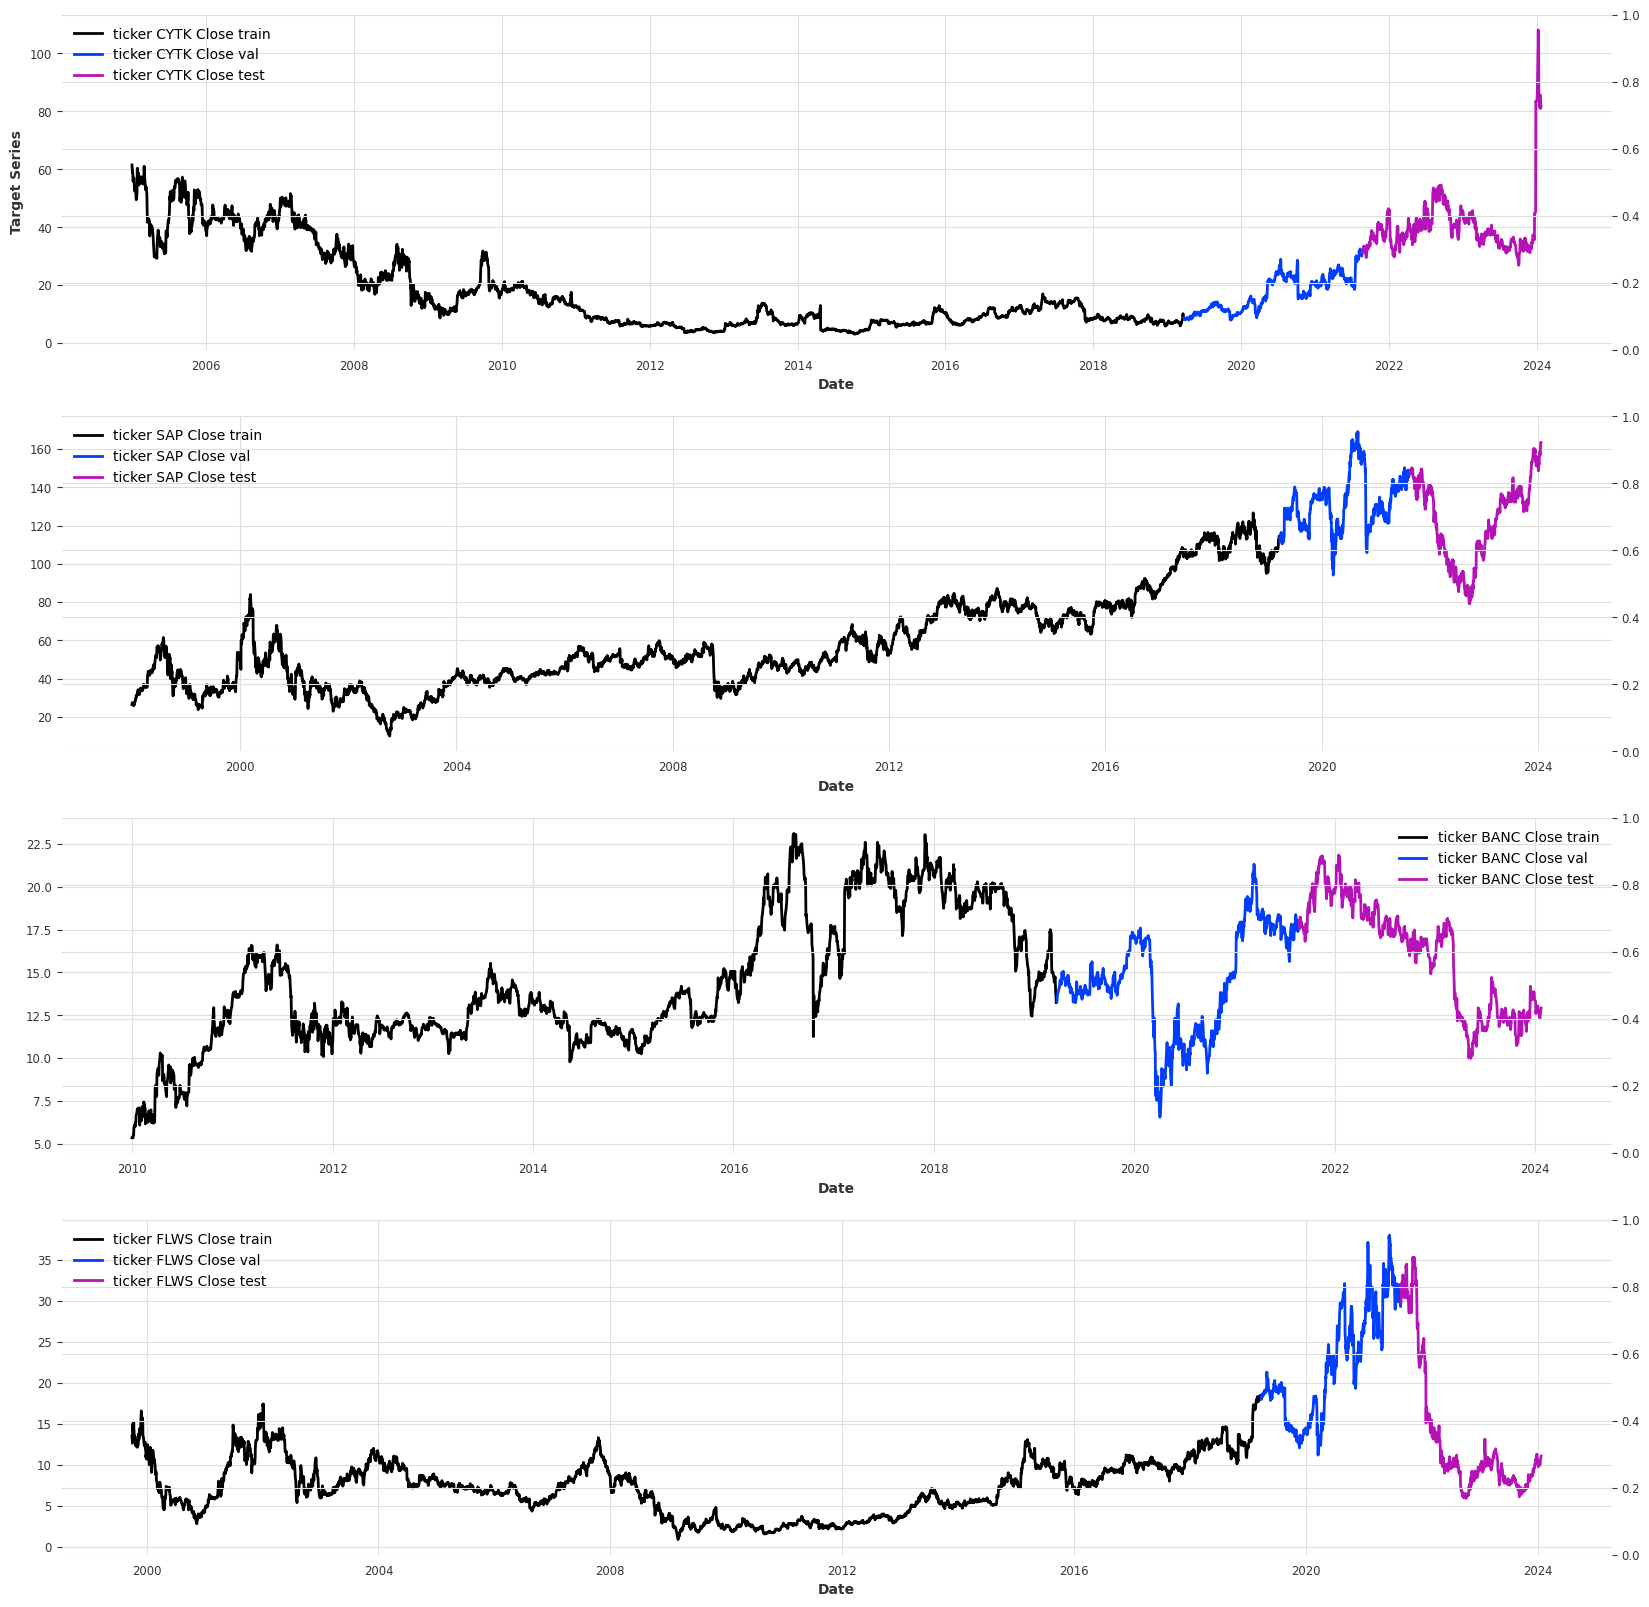

In [ ]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break

    train_series[t]['Close'].plot(label=f'ticker {t} Close train', ax=axes[i])
#    train_series[t]['Volume'].plot(label=f'ticker {t} Volume train', ax=axes2[i])

    val_series[t]['Close'].plot(label=f'ticker {t} Close val', ax=axes[i])
#    val_series[t]['Volume'].plot(label=f'ticker {t} Volume val', ax=axes2[i])

    test_series[t]['Close'].plot(label=f'ticker {t} Close test', ax=axes[i])
#    test_series[t]['Volume'].plot(label=f'ticker {t} Volume test', ax=axes2[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

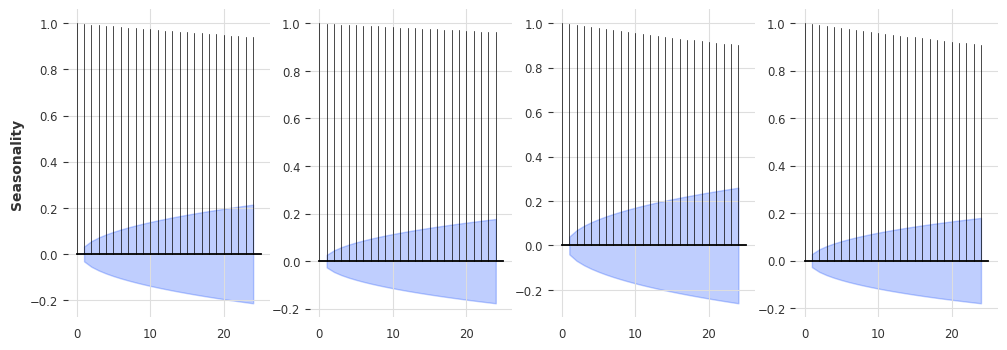

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t]['Close'], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [ ]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [ ]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    # "accelerator": "auto",
    "accelerator": "gpu", 
    "accelerator": "gpu",
    "devices": [0],
    # "auto_select_gpus": True,
    "callbacks": [],
}

# pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256, # 512,
    "random_state": 42,
}

In [ ]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  if torch.cuda.is_available():
    map_location="cuda"
    # utilize CUDA tensor cores with bfloat16
    # https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
    torch.set_float32_matmul_precision('medium') #  | 'high'
  else:
    map_location="cpu"
  model = TiDEModel.load(saved_model_name, map_location=map_location)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  # using TiDE hyperparameters from Table 8 in section B.3 of the original paper
  # https://arxiv.org/pdf/2304.08424.pdf
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=128,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=1
  )
  


Loading saved model


In [ ]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [ ]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


47
47
47
47
47
47
47


In [ ]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [ ]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


1625
1801
630
630
631
631
2886


In [ ]:
target_train_list[0].pd_dataframe()

component        Open   Close
Date                         
2012-12-31  16.389999  16.420
2013-01-01  16.540000  16.545
2013-01-02  16.690001  16.670
2013-01-03  16.730000  16.650
2013-01-04  16.750000  17.000
...               ...     ...
2019-03-18  15.520000  15.490
2019-03-19  15.500000  15.280
2019-03-20  15.300000  15.290
2019-03-21  15.340000  15.340
2019-03-22  15.320000  15.140

[1625 rows x 2 columns]

In [ ]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('2012-12-31 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
past_cov_list[0].pd_dataframe().columns

Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)

In [ ]:
past_cov_list[0].pd_dataframe()

component        High        Low  Adj Close    Volume  eps  epsEstimated  \
Date                                                                       
2012-04-27  18.030001  17.799999   6.125482  558900.0 -1.0          0.09   
2012-04-30  18.049999  17.760000   6.180481  123800.0 -1.0          0.09   
2012-05-01  18.059999  17.950001   6.187356   91100.0 -1.0          0.09   
2012-05-02  18.070000  17.809999   6.132357  139700.0 -1.0          0.09   
2012-05-03  17.990000  17.600000   6.101419  169000.0 -1.0          0.09   
...               ...        ...        ...       ...  ...           ...   
2019-03-18  15.520000  15.320000   8.741171  253800.0 -1.0          0.33   
2019-03-19  15.530000  15.220000   8.622667  232000.0 -1.0          0.33   
2019-03-20  15.380000  15.190000   8.628310  178900.0 -1.0          0.33   
2019-03-21  15.490000  15.280000   8.656526  274600.0 -1.0          0.33   
2019-03-22  15.360000  15.120000   8.543662  297800.0 -1.0          0.33   

component   time  revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                              ...   
2012-04-27   0.0     -1.0         7020000.0                 -1.0  ...   
2012-04-30   0.0     -1.0         7020000.0                 -1.0  ...   
2012-05-01   0.0     -1.0         7020000.0                 -1.0  ...   
2012-05-02   0.0     -1.0         7020000.0                 -1.0  ...   
2012-05-03   0.0     -1.0         7020000.0                 -1.0  ...   
...          ...      ...               ...                  ...  ...   
2019-03-18   0.0     -1.0        32886700.0                 -1.0  ...   
2019-03-19   0.0     -1.0        32886700.0                 -1.0  ...   
2019-03-20   0.0     -1.0        32886700.0                 -1.0  ...   
2019-03-21   0.0     -1.0        32886700.0                 -1.0  ...   
2019-03-22   0.0     -1.0        32886700.0                 -1.0  ...   

component      ^NDX_Low   ^NDX_Close  ^NDX_Adj Close   ^NDX_Volume  \
Date                                                                 
2012-04-27  2723.159912  2741.340088     2741.340088  1.777750e+09   
2012-04-30  2720.439941  2723.679932     2723.679932  1.633170e+09   
2012-05-01  2715.750000  2726.919922     2726.919922  1.854230e+09   
2012-05-02  2707.629883  2734.770020     2734.770020  1.825190e+09   
2012-05-03  2697.780029  2704.590088     2704.590088  1.869130e+09   
...                 ...          ...             ...           ...   
2019-03-18  7293.850098  7326.279785     7326.279785  2.302140e+09   
2019-03-19  7321.930176  7349.279785     7349.279785  2.457920e+09   
2019-03-20  7318.419922  7380.750000     7380.750000  2.464230e+09   
2019-03-21  7356.939941  7493.270020     7493.270020  2.502810e+09   
2019-03-22  7323.520020  7326.060059     7326.060059  2.504740e+09   

component     ^SPX_Open    ^SPX_High     ^SPX_Low   ^SPX_Close  \
Date                                                             
2012-04-27  1400.189941  1406.640015  1397.310059  1403.359985   
2012-04-30  1403.260010  1403.260010  1394.000000  1397.910034   
2012-05-01  1397.859985  1415.319946  1395.729980  1405.819946   
2012-05-02  1405.500000  1405.500000  1393.920044  1402.310059   
2012-05-03  1402.319946  1403.069946  1388.709961  1391.569946   
...                 ...          ...          ...          ...   
2019-03-18  2822.610107  2835.409912  2821.989990  2832.939941   
2019-03-19  2840.760010  2852.419922  2823.270020  2832.570068   
2019-03-20  2831.340088  2843.540039  2812.429932  2824.229980   
2019-03-21  2819.719971  2860.310059  2817.379883  2854.879883   
2019-03-22  2844.520020  2846.159912  2800.469971  2800.709961   

component   ^SPX_Adj Close   ^SPX_Volume  
Date                                      
2012-04-27     1403.359985  3.645830e+09  
2012-04-30     1397.910034  3.574010e+09  
2012-05-01     1405.819946  3.807950e+09  
2012-05-02     1402.310059  3.803860e+09  
2012-05-03     1391.569946  4.004

In [ ]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('2012-04-27 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
target_test_list[0].start_time(), target_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
past_cov_test_list[0].start_time(), past_cov_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                               1.150000e+02
estimatedRevenueLow_p_1                6.533237e+10
estimatedRevenueHigh_p_1               7.585248e+10
estimatedRevenueAvg_p_1                7.059562e+10
estimatedEbitdaLow_p_1                 2.189555e+10
                                           ...     
numberAnalystEstimatedRevenue_p_2_1    5.772000e+03
numberAnalystsEstimatedEps_p_2_1       3.144000e+03
fiscalDateEnding_day_p_2_1             8.946600e+04
fiscalDateEnding_month_p_2_1           3.463200e+04
fiscalDateEnding_year_p_2_1            5.826926e+06
Length: 139, dtype: float64

In [ ]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1', 'estimatedSgaExpenseAvg_p_2_1',
       'estimatedEpsAvg_p_2_1', 'estimatedEpsHigh_p_2_1',
       'estimatedEpsLow_p_2_1', 'numberAnalystEstimatedRevenue_p_2_1',
       'numberAnalystsEstimatedEps_p_2_1', 'fiscalDateEnding_day_p_2_1',
       'fiscalDateEnding_month_p_2_1', 'fiscalDateEnding_year_p_2_1'],
      dtype='object', name='component', length=139)

In [ ]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('2012-12-31 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Run model training loop

In [ ]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=4, ) # num_loader_workers recommended at 4*n_GPUs
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 4     
4 | past_cov_projection   | _ResidualBlock   | 73.3 K
5 | future_cov_projection | _ResidualBlock   | 74.3 K
6 | encoders              | Sequential       | 6.4 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 34.4 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.761    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


TiDEModel(num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=128, use_layer_norm=True, dropout=0.2, use_static_covariates=True, optimizer_kwargs={'lr': 0.000224}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'gpu', 'devices': [0], 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=512, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, use_reversible_instance_norm=True, n_epochs=10, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt, log_tensorboard=True, nr_epochs_val_period=1)

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
# pred[0]

In [ ]:
# pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [ ]:
import matplotlib.dates as mdates

def get_val_start_list():
    val_start_list = []
    for t, target in sorted(target_series.items()):
        val_start_list.append(val_start[t])
    return val_start_list


def get_test_start_list():
    val_test_list = []
    for t, target in sorted(target_series.items()):
        val_test_list.append(test_start[t])
    return val_test_list


def get_pred_start(start_times=None, offset=None):
    pred_start = {}
    bdays_offset = BDay(n=train_history + offset*pred_horizon)
    for t, start_time in start_times.items():
        pred_start[t] = start_time + bdays_offset
    return pred_start    

def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start[t]-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_cov_list(pred_start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start[t]-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list

def get_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list, num_loader_workers=4)
    return pred

pred_test_outputs = []
# get predictions at several points in time over the validation set
for w in range(3):
    pred_start = get_pred_start(start_times=test_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_test_outputs.append(pred)


pred_val_outputs = []
# get predictions at several points in time over the validation set
for w in range(10):
    pred_start = get_pred_start(start_times=val_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_val_outputs.append(pred)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

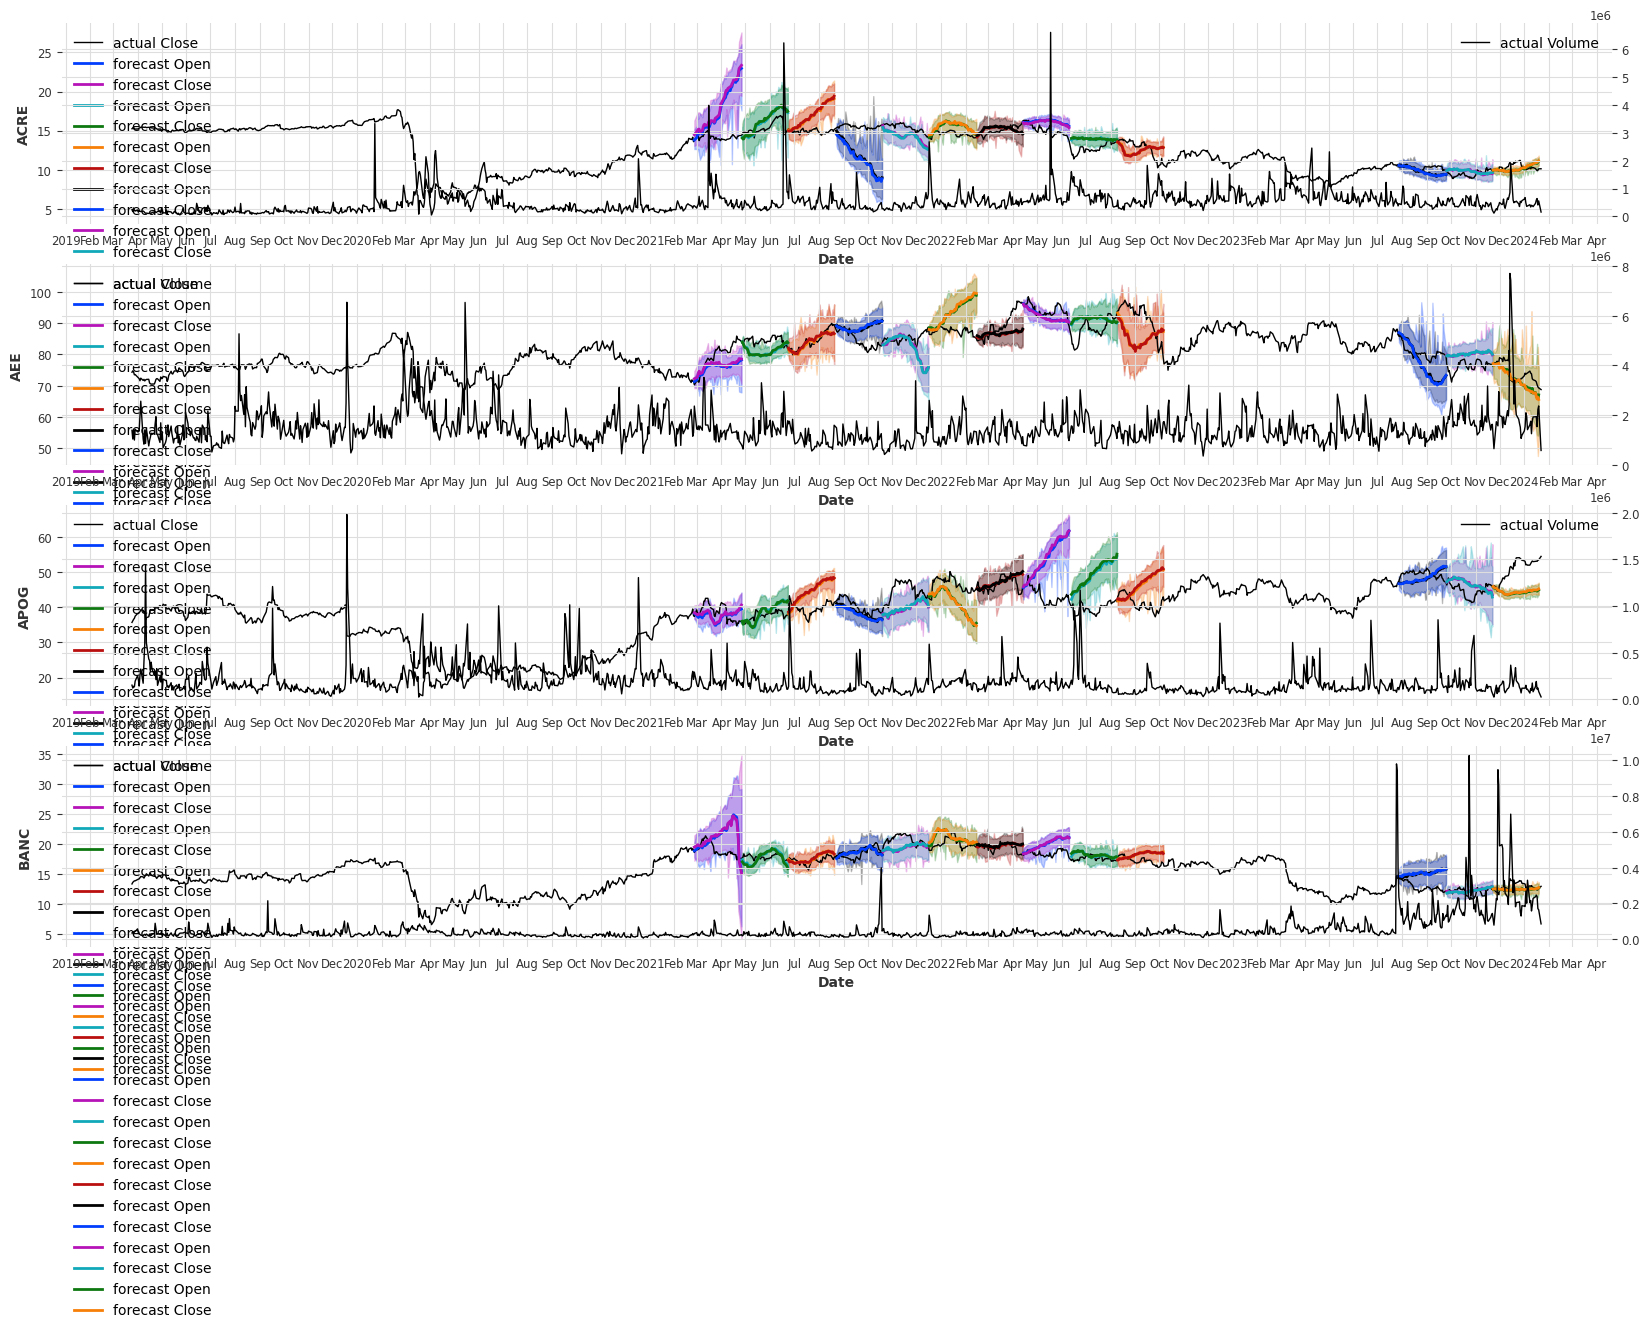

In [ ]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start[t], target.end_time())
            # ax = actual[t]['Open'].plot(label='actual Open', linewidth=1, ax=axes[i])
            ax = actual[t]['Close'].plot(label='actual Close', linewidth=1, ax=axes[i])
            vol = past_covariates[t]['Volume'].slice(val_start[t], target.end_time())
            vol.plot(label='actual Volume', linewidth=1, ax=axes2[i])


def plot_pred(pred_out=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            ax = pred_out[i]['Open'].plot(label=f'forecast Open', linewidth=2, ax=axes[i])
            ax = pred_out[i]['Close'].plot(label=f'forecast Close', linewidth=2, ax=axes[i])
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')



fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 12))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

plot_actual()

# plot predictions at several points in time over the validation set
# plot_pred(pred_outputs=pred_outputs, past_cov_list=past_cov_list)
for pred_out in pred_val_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)

for pred_out in pred_test_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)


### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          stride=forecast_horizon // 2,
                                          last_points_only=False,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 4, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
# forecast_start = test_start-BDay(n=30)
pred_start_list = get_test_start_list()
forecast_start = pred_start_list[0]-BDay(n=30)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[0], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[0], future_covariates=future_cov_list[0])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast_start

Timestamp('2021-07-12 00:00:00')

In [ ]:
forecast_horizon

42

In [ ]:
targets_list[0].start_time()

Timestamp('2012-12-31 00:00:00')

In [ ]:
backtest[0]

<TimeSeries (DataArray) (Date: 42, component: 2, sample: 500)>
array([[[15.00473824, 15.04736737, 15.02991518, ..., 15.0037274 ,
         16.22522457, 15.00642532],
        [15.04314291, 14.67388719, 14.67263888, ..., 15.5013832 ,
         15.53750164, 14.67343968]],

       [[14.87522459, 14.42016825, 15.74773258, ..., 15.48878881,
         15.149632  , 14.60049733],
        [15.25401479, 14.63768535, 14.64014106, ..., 14.47257792,
         15.93385609, 15.31161952]],

       [[14.22961463, 14.83131935, 17.11308394, ..., 15.9822443 ,
         14.98409493, 15.29103386],
        [15.94192699, 15.5333619 , 15.21441021, ..., 15.23362842,
         15.60023491, 16.03487124]],

       ...,

       [[17.87692899, 17.4612024 , 18.88719635, ...,  7.40781888,
         17.76549826, 17.58332594],
        [18.04261141, 17.32790937, 19.14201717, ..., 18.16016389,
         19.7887178 , 17.35779855]],

       [[17.99815038, 19.3174861 , 17.49893266, ..., 16.49267867,
         18.11971445, 17.17734971],
        [17.82517522, 19.30819383, 16.81845792, ..., 17.11327405,
         19.30108858, 19.72878215]],

       [[17.0102174 , 18.3530178 , 17.48407673, ..., 19.87462941,
         18.25388886, 18.79909229],
        [18.20096507, 18.23209576, 17.32624477, ..., 16.78745258,
         19.21472131, 19.31073503]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2021-07-12 2021-07-13 ... 2021-09-07
  * component  (component) object 'Open' 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


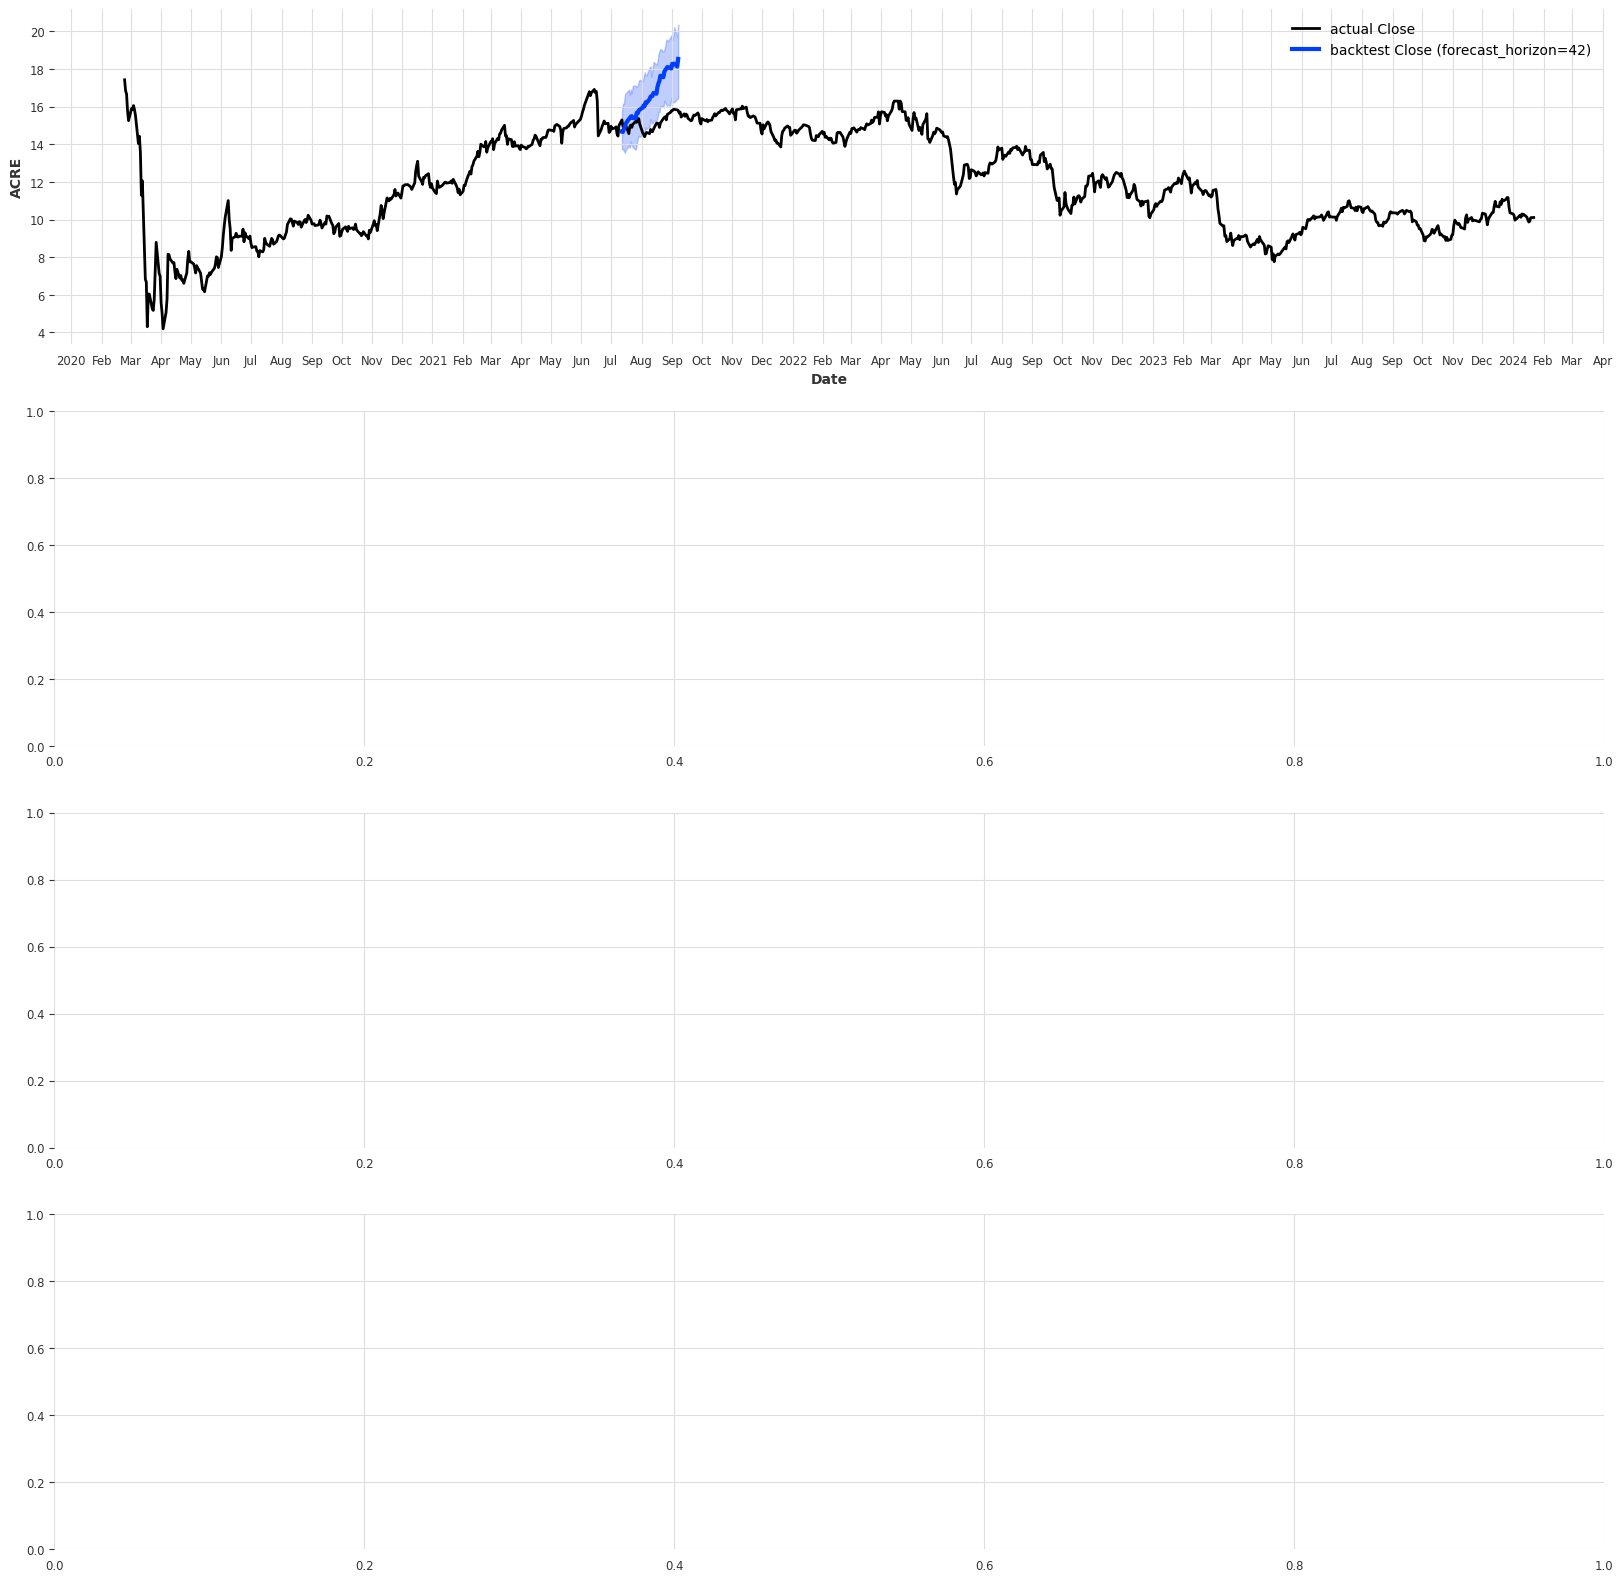

In [ ]:


fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
# axes2 = {}
# for i in range(n_plot_samples):
#    axes2[i] = axes[i].twinx()

for i,t in enumerate(sorted(train_series.keys())):
    # if i < n_plot_samples:
    if i == 0:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(forecast_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t]['Close'].plot(label='actual Close', linewidth=2, ax=axes[i])
        # actual[t]['Volume'].plot(label='actual Volume', ax=axes2[i])
        backtest[i]['Close'].plot(label=f'backtest Close (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        # backtest[i]['Volume'].plot(label=f'backtest Volume (forecast_horizon={forecast_horizon})', linewidth=1, ax=axes2[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13), interval=1))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
assert len(target_train_list[0].gaps()) == 0 # :n_plot_samples]

In [ ]:
len(target_train_list[0])

1625

In [ ]:
len(target_train_list[0][:len(backtest[0])])

42

In [ ]:
assert len(backtest[0].gaps()) == 0

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [ ]:
len(backtest[0])

42

In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[0], backtest[0])))


Backtest RMSE = nan


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
